In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np

from tqdm import tqdm
from datetime import timedelta
from sklearn.decomposition import NMF


In [2]:
tqdm.pandas()

In [3]:
billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958


In [4]:
plt.rcParams.update({'font.size': 15})

In [5]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(
    ["artist", "song_name"])["position"].transform("min")

In [6]:
# concatenate artist and song name
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " +\
    billboard_hot_100["song_name"]
billboard_hot_100["first_week"] = billboard_hot_100.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")
billboard_hot_100["last_week"] = billboard_hot_100.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("max")
billboard_hot_100["start_end_week_diff"] = (billboard_hot_100["last_week"] - billboard_hot_100["first_week"]).dt.days / 7

In [7]:
min_first_week = billboard_hot_100["first_day_of_the_week"].min().to_pydatetime()
billboard_hot_100["first_day_of_the_week_copy"] = billboard_hot_100["first_day_of_the_week"]
billboard_hot_100["first_day_of_the_week"] = billboard_hot_100.progress_apply(lambda row:
            int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

100%|██████████| 336087/336087 [00:08<00:00, 38317.33it/s]


In [8]:
billboard_hot_100 = billboard_hot_100[billboard_hot_100["start_end_week_diff"] <= 100]

pv_table = billboard_hot_100[billboard_hot_100["start_end_week_diff"] <= 100].pivot_table(index="first_day_of_the_week",
        columns="artist_song", values="position", fill_value=101)

In [9]:
pv_table

artist_song,"""Groove"" Holmes - Misty","""Groove"" Holmes - What Now My Love","""Little"" Jimmy Dickens - May The Bird Of Paradise Fly Up Your Nose","""Pookie"" Hudson - I Know I Know","""Weird Al"" Yankovic - Amish Paradise","""Weird Al"" Yankovic - Canadian Idiot","""Weird Al"" Yankovic - Eat It","""Weird Al"" Yankovic - Fat","""Weird Al"" Yankovic - I Lost On Jeopardy","""Weird Al"" Yankovic - King Of Suede",...,twenty one pilots - Stressed Out,twenty one pilots - Tear In My Heart,will.i.am & Britney Spears - Scream & Shout,will.i.am & Nicki Minaj - Check It Out,will.i.am - I Got It From My Mama,will.i.am - It's A New Day,will.i.am Featuring Justin Bieber - #thatPOWER,will.i.am Featuring Mick Jagger & Jennifer Lopez - T.H.E (The Hardest Ever),will.i.am Featuring Miley Cyrus - Fall Down,"will.i.am Featuring Miley Cyrus, French Montana, Wiz Khalifa & DJ Mustard - Feelin' Myself"
first_day_of_the_week,,,,,,,,,,,,,,,,,,,,,
0,100,98,90,96,65,82,59,99,83,77,...,87,82,12,78,93,78,42,36,58,96
1,85,98,75,101,62,94,36,100,81,66,...,101,101,13,57,57,101,60,90,101,99
2,84,96,59,101,58,98,18,101,97,62,...,101,101,15,42,32,101,65,101,101,101
3,82,101,43,101,53,101,14,101,101,62,...,97,101,12,50,31,101,60,101,101,101
4,64,101,29,101,53,101,13,101,101,91,...,101,101,12,34,33,101,43,101,101,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101
97,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101
98,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101


In [10]:
nmf = NMF(n_components=6, init='random', random_state=0)
nmf.fit(pv_table)

c:\Users\cutie\source\repos\mgr\env\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(init='random', n_components=6, random_state=0)

In [11]:
nmf_features = nmf.transform(pv_table)

In [12]:
def display_components(model, song_names, num_top_positions):
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, archetype in enumerate(model.components_):
        #print topic, topic number, and top words
        print("\nArchetype ", ix)
        print(", ".join([song_names[i] \
             for i in archetype.argsort()[:-num_top_positions - 1:-1]]))

In [13]:
display_components(nmf, billboard_hot_100["artist_song"].values, 5)


Archetype  0
Dee Clark - Nobody But You, Baby Washington - Leave Me Alone, The Ray Charles Singers - Love Me With All Your Heart (Cuando Calienta El Sol), The Belmonts - Diddle-Dee-Dum (What Happens When Your Love Has Gone), The Shields - You Cheated

Archetype  1
Jimmy McGriff - I've Got A Woman (Part I), The Everly Brothers - Cathy's Clown, Nat King Cole - Dear Lonely Hearts, Della Reese - Not One Minute More, The Beatles - She Loves You

Archetype  2
Les Cooper and the Soul Rockers - Wiggle Wobble, Chico Holiday - Young Ideas, Tommy Sands And The Raiders - Blue Ribbon Baby, Connie Francis - Baby's First Christmas, Ray Charles and his Orchestra - I'm Movin' On

Archetype  3
Johnny Tillotson - Why Do I Love You So, The Elegants - Little Star, Freddy Cannon - For Me And My Gal, Mitch Miller With Orchestra And Chorus - Tunes Of Glory, Rod Bernard - This Should Go On Forever

Archetype  4
Bobby Vinton - Trouble Is My Middle Name, Lonnie Mack - Wham!, Little Peggy March - I Wish I Were A

In [14]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(nmf.components_, columns=billboard_hot_100["artist_song"].drop_duplicates().values)
components_df

,Domenico Modugno - Nel Blu Dipinto Di Blu (Volare),The Elegants - Little Star,The Everly Brothers - Bird Dog,Jimmy Clanton And His Rockets - Just A Dream,Perez Prado And His Orchestra - Patricia,Ricky Nelson - Poor Little Fool,Jack Scott - My True Love,Bobby Day - Rock-in Robin,Frankie Avalon - Ginger Bread,The Olympics - Western Movies,...,Juice WRLD - Face 2 Face,Pentatonix Featuring Meghan Trainor - Kid On Christmas,SZA - Conceited,SZA - Far,Nengo Flow & Bad Bunny - Gato de Noche,Carin Leon X Grupo Frontera - Que Vuelvas,Fuerza Regida X Grupo Frontera - Bebe Dame,SZA - Too Late,SZA Featuring Ol' Dirty Bastard - Forgiveless,A Boogie Wit da Hoodie Featuring Kodak Black - Water (Drowning Pt. 2)
0,6.712761,4.244811,7.900613,4.276230,3.697319,3.838891,6.209409,4.328167,3.658404,3.216134,...,3.322749,3.616163,0.000000,5.916424,5.489285,3.565194,2.433716,4.202236,3.450334,4.245952
1,1.143993,3.389797,0.000000,3.388651,3.030488,3.559812,0.366866,3.366080,3.622189,3.560083,...,0.000000,3.880702,8.970253,1.209757,1.458417,3.762006,4.100062,2.857484,3.703979,3.399580
2,1.421576,5.095770,0.696117,5.066720,3.243672,5.309513,1.681048,5.041515,5.426324,5.761361,...,4.571519,5.220425,0.267200,0.921783,3.987310,5.238913,0.533740,3.737644,5.496159,5.085748
3,3.896325,4.670527,1.794870,4.778982,2.010055,4.451850,0.000000,4.796898,4.230194,2.626016,...,4.891235,4.675509,0.000000,1.708814,0.549711,4.612193,2.608340,4.212276,4.323905,4.745609
4,2.013253,3.601462,1.000507,3.536198,6.124424,4.297927,4.202508,3.446990,4.614675,5.675858,...,0.883133,4.389545,1.226952,4.019444,3.545666,4.688673,8.769580,5.005502,4.953221,3.588943
5,3.441731,0.338149,5.670870,0.291856,2.559326,0.170144,5.626055,0.320212,0.178172,0.879835,...,0.000000,0.012060,9.438282,4.741010,4.151760,0.000000,2.657380,0.993222,0.000000,0.290721


In [15]:
# get all artist-songs for archetypes
archetypes = {i: [] for i in range(6)}
for artist_song in components_df.columns:
    archetype = components_df[artist_song].argmax()
    archetypes[archetype].append(artist_song)


In [16]:
nmf_features_pd = pd.DataFrame(nmf_features)

nmf_features_pd

,0,1,2,3,4,5
0,8.223014,3.978808,0.000000,9.414610,0.275293,2.458792
1,5.272343,2.192854,1.249924,13.632173,0.000000,1.224599
2,2.738851,0.983310,3.697419,14.194439,0.000000,0.728211
3,1.046732,0.222141,5.959879,13.793493,0.000000,0.324889
4,0.033079,0.000000,8.358257,12.257090,0.000000,0.000000
...,...,...,...,...,...,...
96,6.844615,4.506156,3.854050,4.224038,4.339351,5.648779
97,6.843458,4.505728,3.854546,4.224438,4.339677,5.648992
98,6.843914,4.506326,3.854590,4.223700,4.339463,5.648613
99,6.844120,4.506627,3.854668,4.223271,4.339348,5.648443


In [17]:
approx_song_i = np.matmul(nmf_features_pd, components_df.values[:, 54])

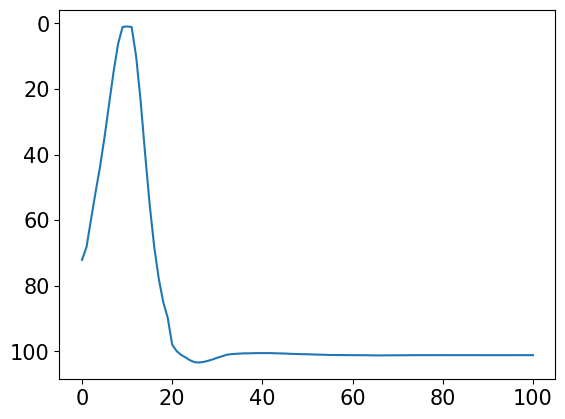

In [18]:
plt.plot(range(0, 101), approx_song_i)
plt.gca().invert_yaxis()
plt.show()

In [19]:
rows_to_add = []

grouped = billboard_hot_100.groupby(["artist", "song_name"])

for name, group in tqdm(grouped):
    max_week = group["first_day_of_the_week"].max()

    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            week = row["first_day_of_the_week"] + 1

            while week <= 101:
                rows_to_add.append({
                    "artist_song": row["artist_song"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": 101,
                    "first_day_of_the_week": week,
                    "top_position": row["top_position"],
                    "first_week": row["first_week"]
                })
                week += 1

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100[["artist_song",
    "weeks_on_chart", "position", "first_day_of_the_week", "first_week", "top_position"]], pd.DataFrame(rows_to_add)], ignore_index=True)

100%|██████████| 30241/30241 [01:03<00:00, 473.20it/s]


6it [00:35,  5.88s/it]


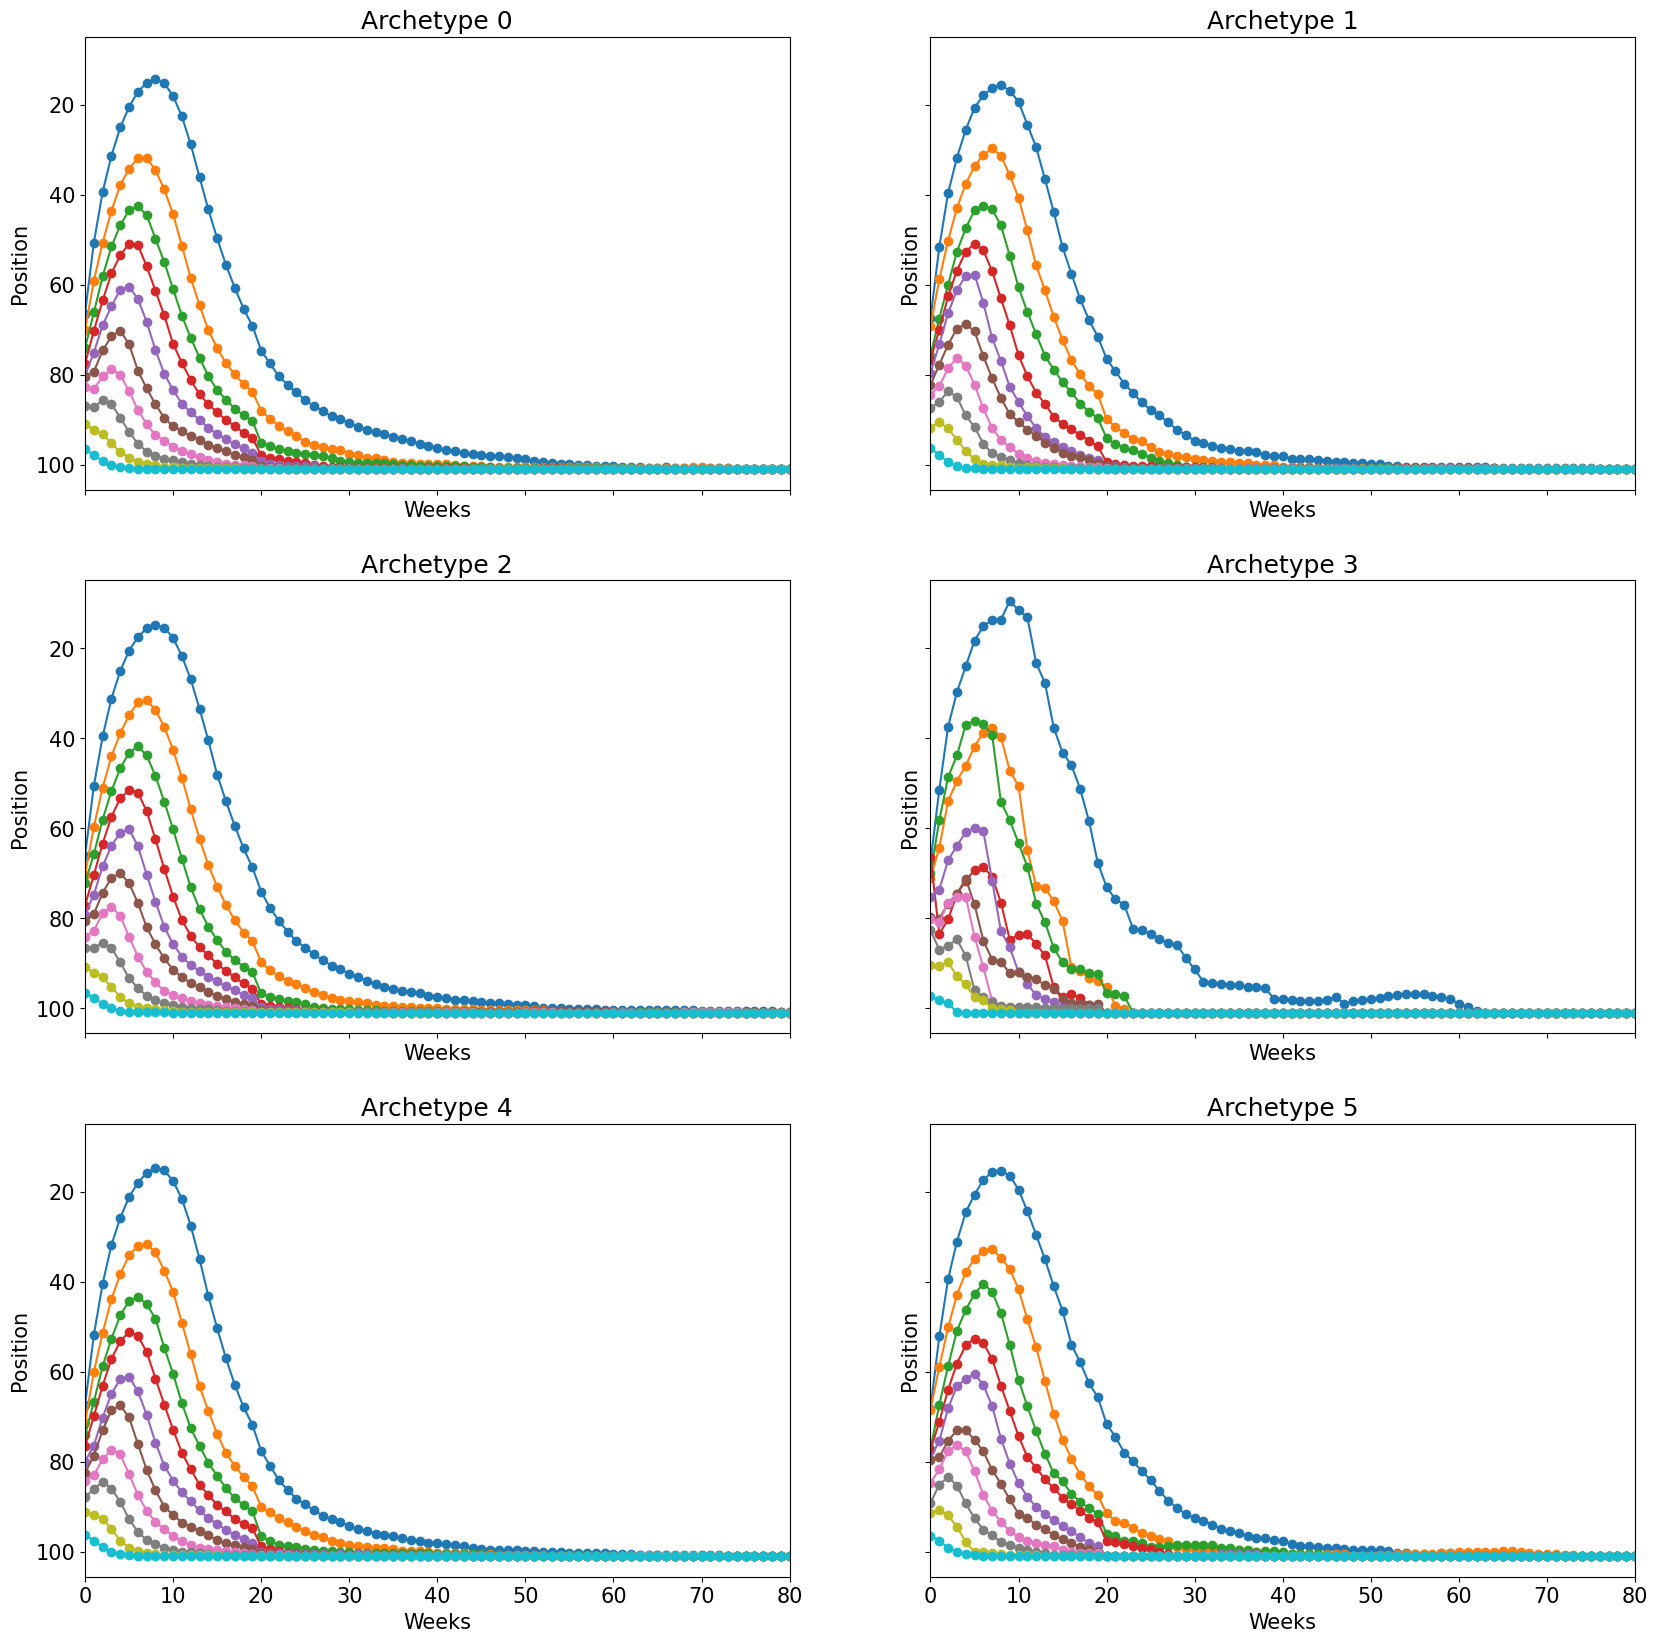

In [20]:
# plot all trajectories of archetypes
fig, axes = plt.subplots(int(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for top_position in range(10, 110, 10):
        songs_ids_from_archetype = archetypes[ix]
        songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        songs_from_archetype = songs_from_archetype[(songs_from_archetype["top_position"] <= top_position) &\
            (songs_from_archetype["top_position"] > top_position - 10)][["artist_song"]]
        songs_from_archetype = songs_from_archetype[["artist_song"]].drop_duplicates().merge(
            billboard_100_with_empty_weeks[["artist_song",
                "position", "first_day_of_the_week", "first_week"]], on=["artist_song"], how="left")
        axes[row_i, col_i].plot(songs_from_archetype.groupby("first_day_of_the_week")["position"].mean(),
            marker='o')
        
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.xlim(0, 80)
plt.gca().invert_yaxis()
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1010.68it/s]
6it [00:09,  1.53s/it]


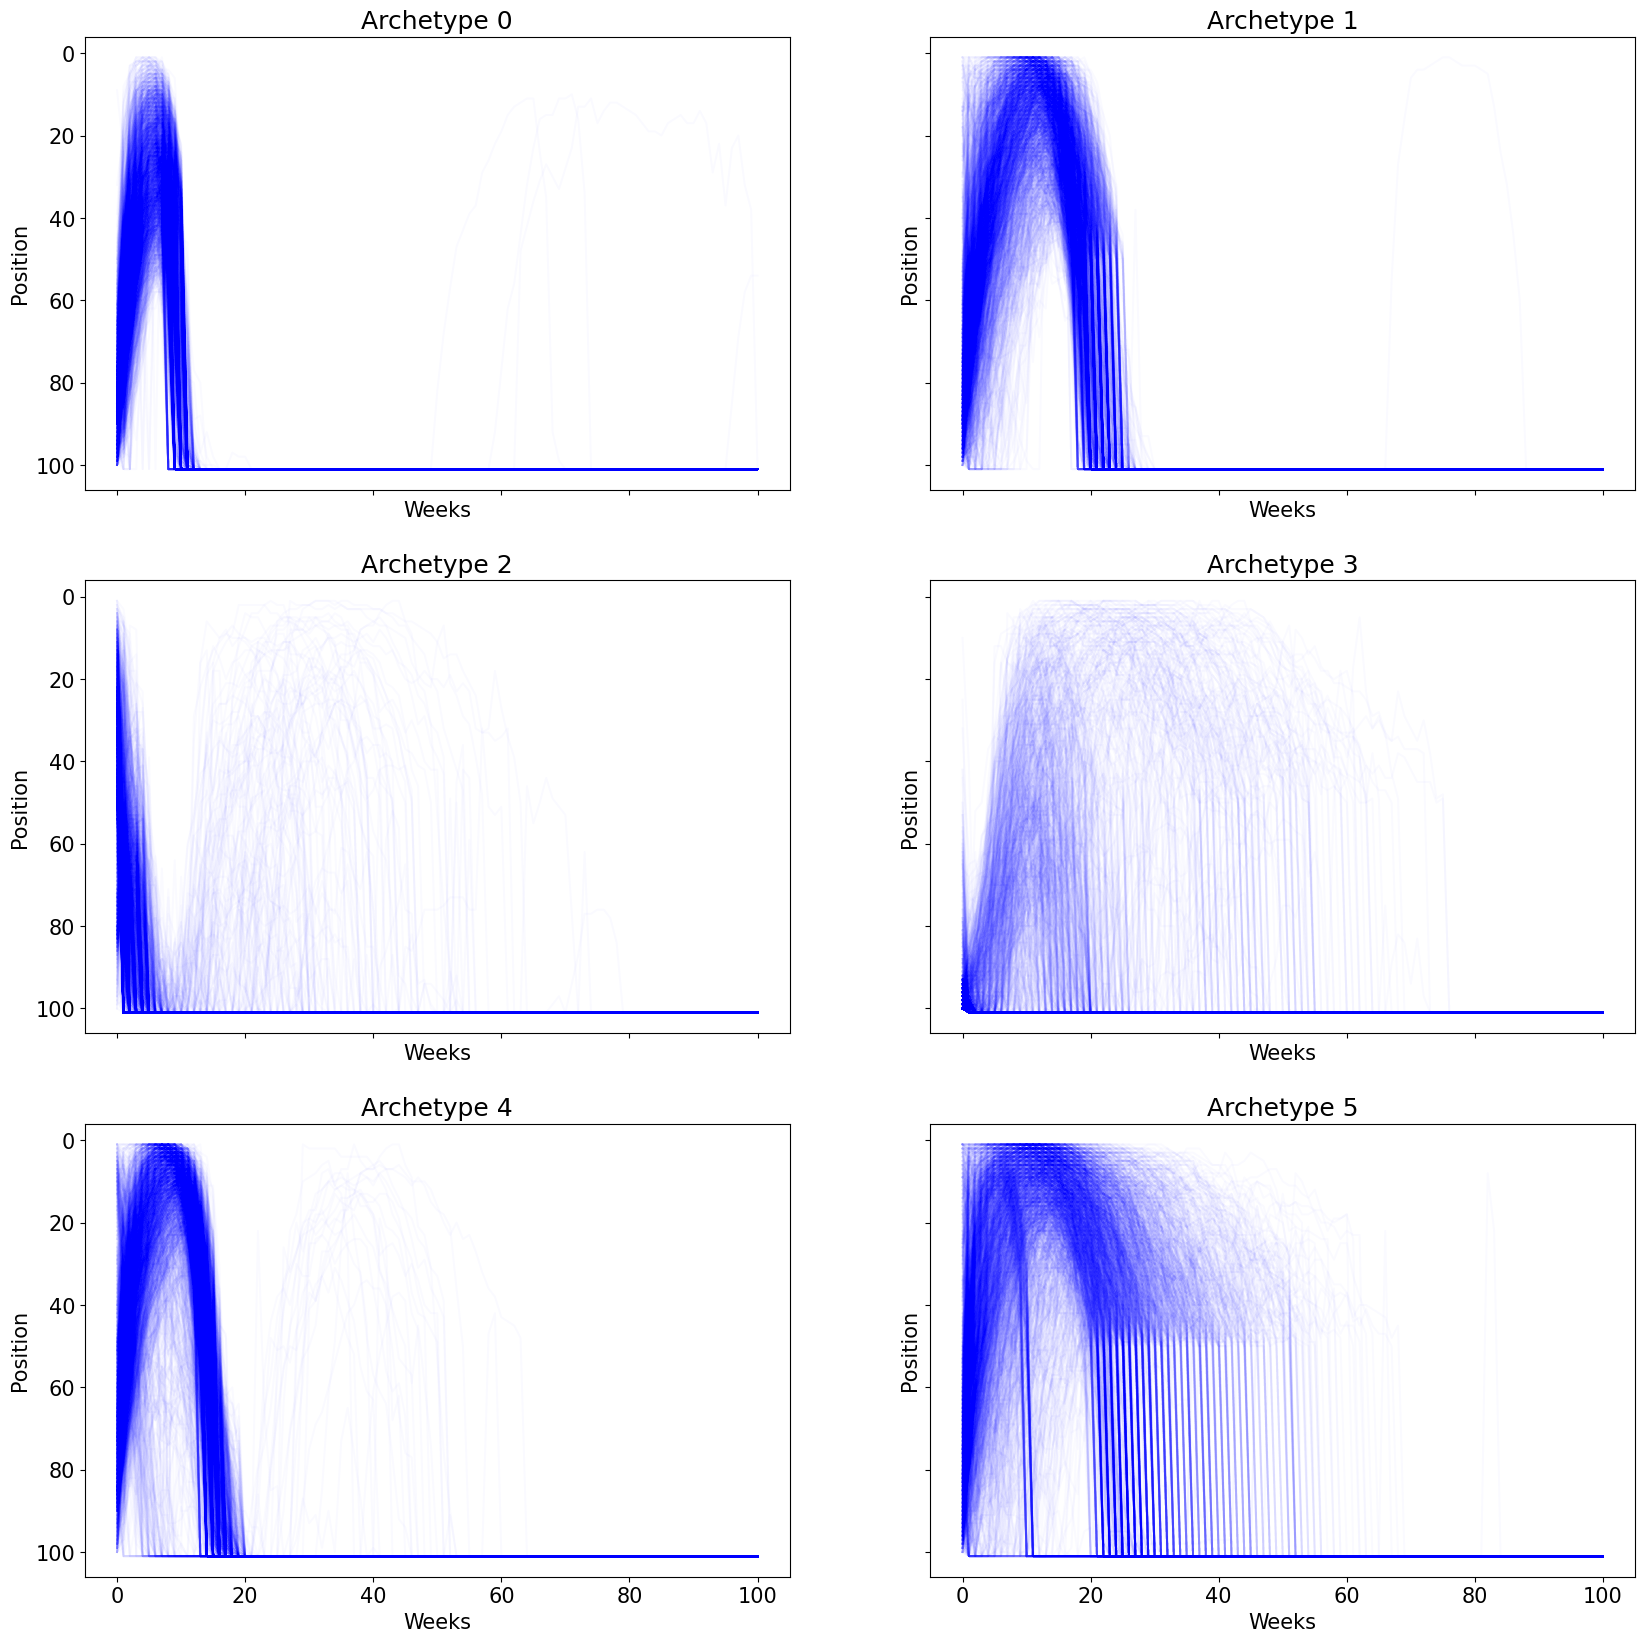

In [21]:
fig, axes = plt.subplots(int(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        # songs_ids_from_archetype = archetypes[ix]
        # songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        trajectory = pv_table.iloc[:, i].values
        #trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1118.82it/s]
6it [00:10,  1.81s/it]


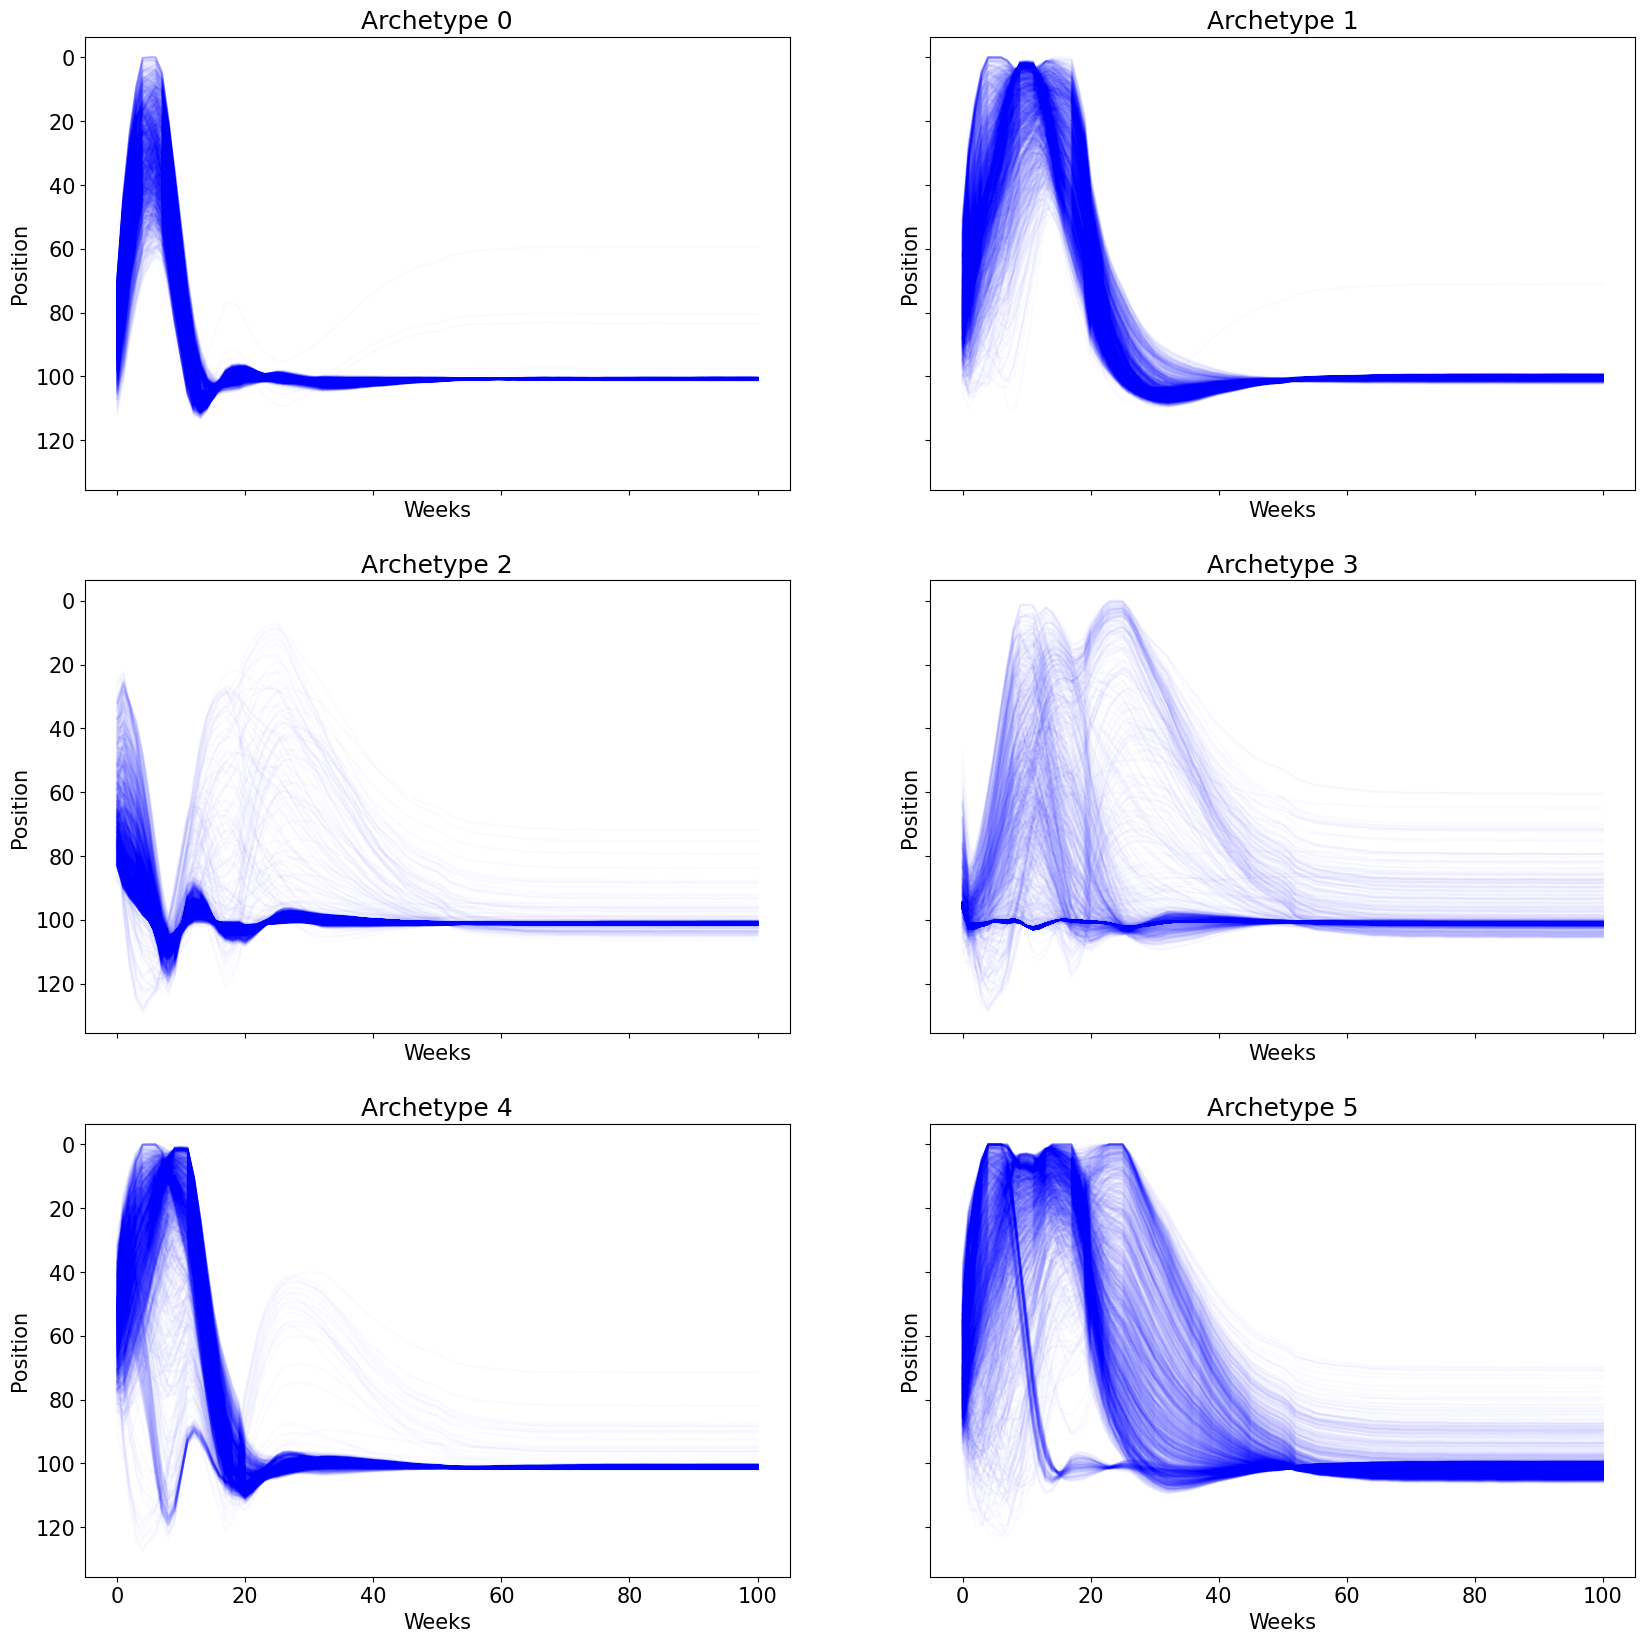

In [22]:
fig, axes = plt.subplots(int(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        # songs_ids_from_archetype = archetypes[ix]
        # songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        trajectory = np.matmul(nmf_features_pd, components_df.values[:, i])
        trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.show()

In [23]:
billboard_hot_100["archetype"] = billboard_hot_100["artist_song"].progress_apply(lambda x: components_df[x].argmax())


100%|██████████| 332359/332359 [00:16<00:00, 20490.32it/s]


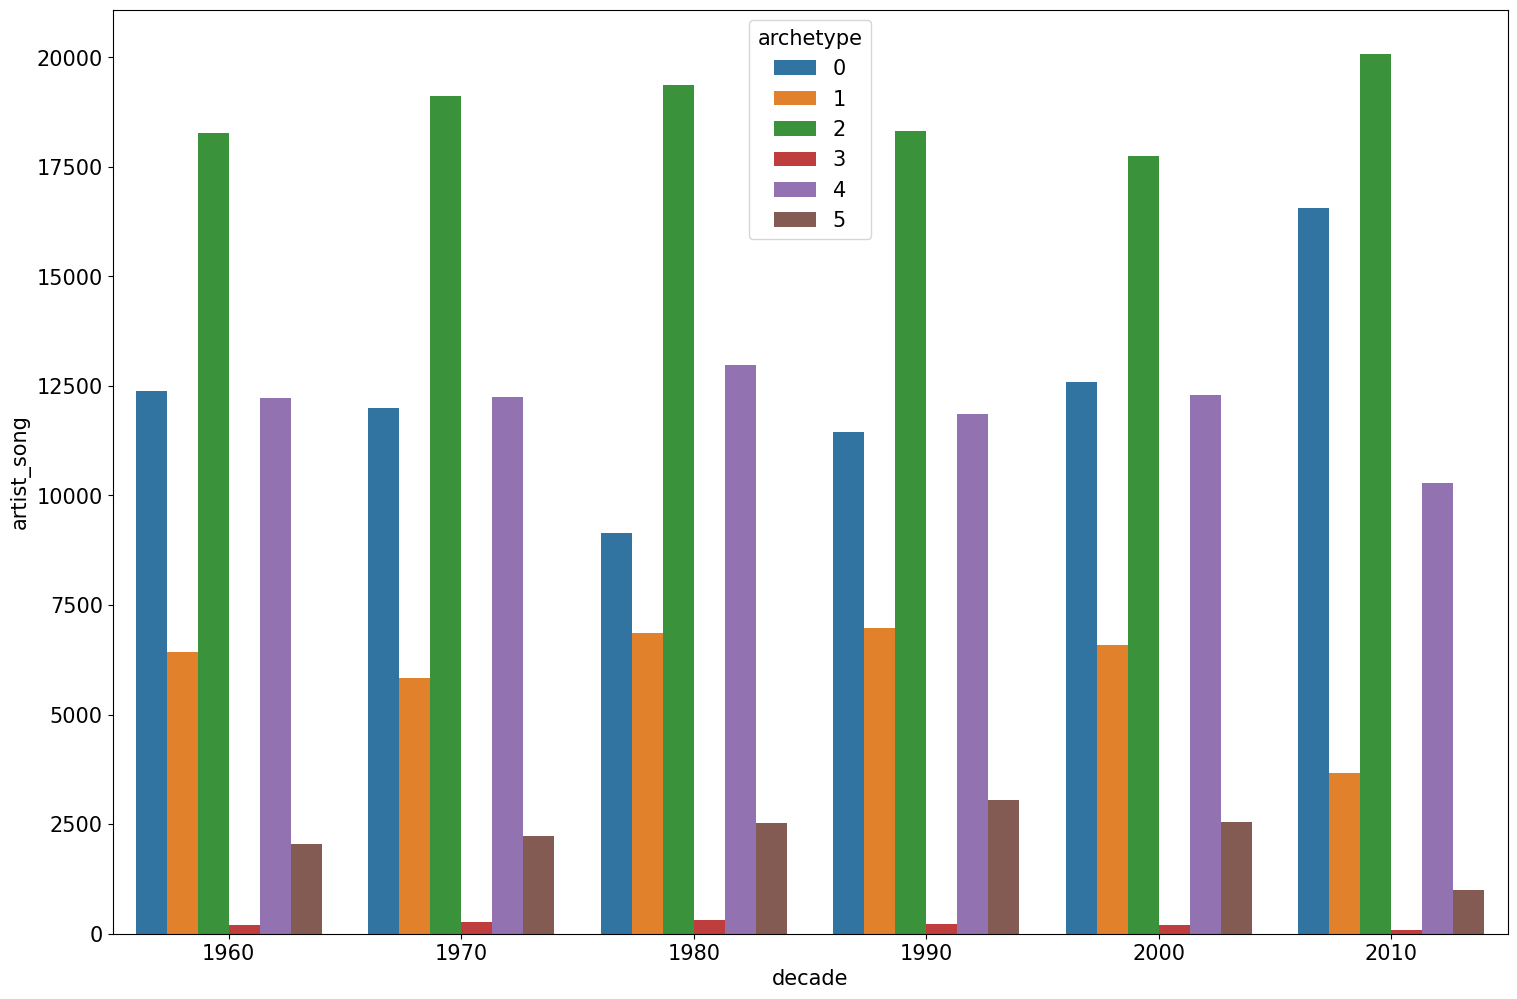

In [24]:
import seaborn as sns

plt.figure(figsize=(18, 12))

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week_copy"].dt.year
billboard_hot_100["decade"] = billboard_hot_100["year"].apply(lambda x: x - x % 10)
counts = billboard_hot_100[["archetype", "decade", "artist_song"]].groupby(["archetype", "decade"]).count().reset_index()
counts = counts[(counts["decade"] != 2020) & (counts["decade"] != 1950)]
sns.barplot(counts, x="decade", y="artist_song", hue="archetype")

plt.show()